In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import random as rn
import pickle
from tqdm import tqdm
%matplotlib inline

In [2]:
import os
os.environ['PYTHONHASHSEED'] = '0'

In [3]:
np.random.seed(42)

In [4]:
rn.seed(42)

In [5]:
pd.options.display.max_columns = None

In [6]:
#!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.107 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/9994/752467/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1627830051&Signature=NRH9U6%2ByuQtWzzPMuPWhgW%2Bo83w065WJboMDE1JrjiH9ge%2BXoz2AI7SD62hDf%2FTj3%2BJ88P%2BStgxZvDWhz3M4At%2F%2BlNlMA66anfPgN3mOFIn%2Fdleho%2BX6D43E6%2BxL94O9L7S%2B658KBJEYgQ%2BZT8ffCL3Wy2bBMdRtoNFsFrAKOrlGlb6BxVBFVJ8aaDzE0CkrTEv%2Fn5fPtNtMF7EgsV8QCt1tEhYFymym1gYCVT%2BW2WNtg71sgwOP%2FKf6cTfYM35NmESPGkLlpGmjzWHicT7U0y9SEWo74K6VJKUHIfLijc6w8KBnPP6I8FDtSvQoParl4sYRtBjn5SyClNdQuGjZhw%3D%3D&response-content-disposition=attachment%3B+filename%3Dashrae-energy-prediction.zip" -c -O 'ashrae-energy-prediction.zip'

In [7]:
#!unzip ashrae-energy-prediction.zip

In [8]:
build=pd.read_csv("../input/ashrae-energy-prediction/building_metadata.csv")
df=pd.read_csv("../input/ashrae-energy-prediction/train.csv")
weather=pd.read_csv("../input/ashrae-energy-prediction/weather_train.csv")

In [9]:
feature_changes={}

In [10]:
encoders={}

In [11]:
build.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   site_id      1449 non-null   int64  
 1   building_id  1449 non-null   int64  
 2   primary_use  1449 non-null   object 
 3   square_feet  1449 non-null   int64  
 4   year_built   675 non-null    float64
 5   floor_count  355 non-null    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   building_id    int64  
 1   meter          int64  
 2   timestamp      object 
 3   meter_reading  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 616.9+ MB


In [13]:
df['timestamp']=pd.to_datetime(df['timestamp'])

In [14]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   site_id             139773 non-null  int64  
 1   timestamp           139773 non-null  object 
 2   air_temperature     139718 non-null  float64
 3   cloud_coverage      70600 non-null   float64
 4   dew_temperature     139660 non-null  float64
 5   precip_depth_1_hr   89484 non-null   float64
 6   sea_level_pressure  129155 non-null  float64
 7   wind_direction      133505 non-null  float64
 8   wind_speed          139469 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 9.6+ MB


In [15]:
weather.isna().sum()/weather.shape[0]*100

site_id                0.000000
timestamp              0.000000
air_temperature        0.039350
cloud_coverage        49.489529
dew_temperature        0.080845
precip_depth_1_hr     35.979052
sea_level_pressure     7.596603
wind_direction         4.484414
wind_speed             0.217496
dtype: float64

In [16]:
build.isna().sum()/build.shape[0]*100

site_id         0.000000
building_id     0.000000
primary_use     0.000000
square_feet     0.000000
year_built     53.416149
floor_count    75.500345
dtype: float64

In [17]:
df.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


In [18]:
#no.of buildings are taken
df['building_id'].nunique()

1449

In [19]:
df.groupby('building_id')['timestamp'].count()

building_id
0       8784
1       8784
2       8784
3       8784
4       8784
        ... 
1444    7445
1445    7449
1446    7472
1447    7471
1448    7452
Name: timestamp, Length: 1449, dtype: int64

clearly we can see that not all buildings are having complete one year data

In [20]:
#types of meter
#{0: electricity, 1: chilledwater, 2: steam, 3: hotwater}
df['meter'].unique(
)

array([0, 3, 1, 2])

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='meter', ylabel='count'>

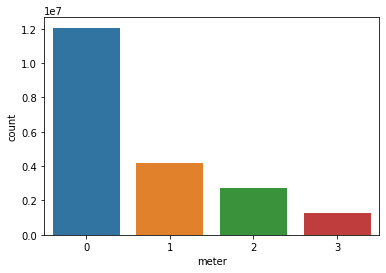

In [21]:
sn.countplot(df['meter'])

In [22]:
#meter_reading for each building caused by which type of meter
pd.crosstab(df['building_id'],df['meter'],values=df['meter_reading'],aggfunc='sum').fillna(value=0)

meter,0,1,2,3
building_id,,,,
0,1.286461e+06,0.0,0.0,0.0
1,6.576176e+05,0.0,0.0,0.0
2,1.278194e+05,0.0,0.0,0.0
3,2.069071e+06,0.0,0.0,0.0
4,8.578074e+06,0.0,0.0,0.0
...,...,...,...,...
1444,5.570443e+04,0.0,0.0,0.0
1445,3.525474e+04,0.0,0.0,0.0
1446,2.684063e+04,0.0,0.0,0.0


In [23]:
#taking meter_reading as per day for each meter 
temp=pd.crosstab(df['timestamp'],df['meter'],values=df['meter_reading'],aggfunc='sum')

In [24]:
temp.rename(columns={0:'m0',1:'m1',2:'m2',3:'m3'},inplace=True)

In [25]:
temp.head()

meter,m0,m1,m2,m3
timestamp,,,,
2016-01-01 00:00:00,146796.9708,52396.5669,3.924435e+06,87655.1681
2016-01-01 01:00:00,166439.5826,59582.4064,3.964789e+06,60670.8718
2016-01-01 02:00:00,166652.5184,58646.9936,9.660917e+05,68204.1314
2016-01-01 03:00:00,166988.5308,55827.6281,7.249452e+05,61265.7329
2016-01-01 04:00:00,167381.4970,53843.3643,8.847084e+05,64722.2291


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-package

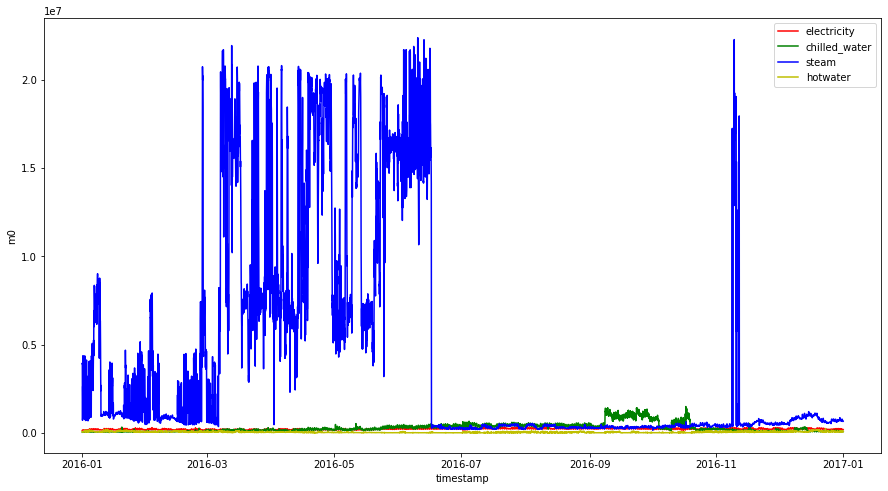

In [26]:
plt.figure(figsize=(15,8))
sn.lineplot(temp.index,temp.m0,color='r',label='electricity')
sn.lineplot(temp.index,temp.m1,color='g',label='chilled_water')
sn.lineplot(temp.index,temp.m2,color='b',label='steam')
sn.lineplot(temp.index,temp.m3,color='y',label='hotwater')
plt.legend(loc=0)

for steam meter_readings are very high when compared with others. From 7Th month to 11th month readings are down. maybe its a summer but hotwater readings are not high

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


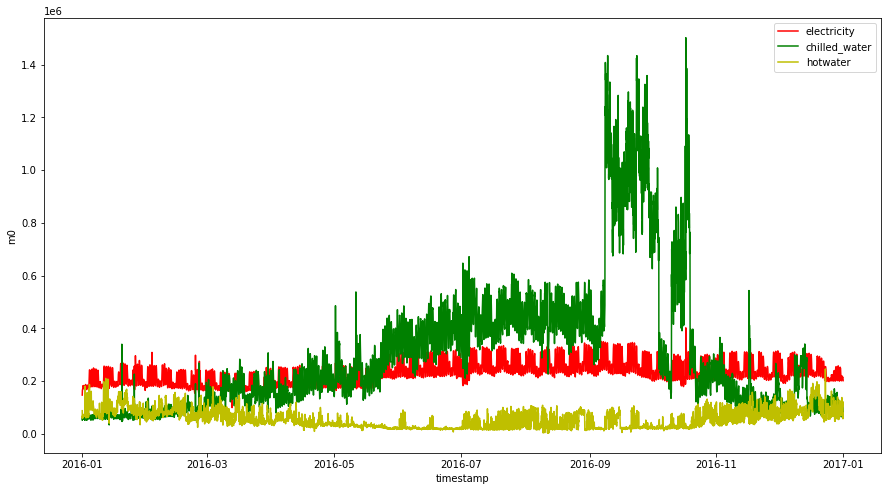

In [27]:
# as the steam reading is dominating removing it and checking patterns of other readings
plt.figure(figsize=(15,8))
sn.lineplot(temp.index,temp.m0,color='r',label='electricity')
sn.lineplot(temp.index,temp.m1,color='g',label='chilled_water')
sn.lineplot(temp.index,temp.m3,color='y',label='hotwater')
plt.legend(loc=0)

we can see that chilled water reading is high in range of 7th month to 11th month. So, it's may be summer in the country this data has been taken

weather analysis

In [28]:
weather.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [29]:
weather.describe()

,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,139773.000000,139718.000000,70600.000000,139660.000000,89484.000000,129155.000000,133505.000000,139469.000000
mean,7.478977,14.418106,2.149306,7.350158,0.983047,1016.158038,180.526632,3.560527
std,4.604744,10.626595,2.599150,9.790235,8.463678,7.629684,111.523629,2.335874
min,0.000000,-28.900000,0.000000,-35.000000,-1.000000,968.200000,0.000000,0.000000
25%,3.000000,7.200000,0.000000,0.600000,0.000000,1011.800000,80.000000,2.100000
50%,7.000000,15.000000,2.000000,8.300000,0.000000,1016.400000,190.000000,3.100000
75%,11.000000,22.200000,4.000000,14.400000,0.000000,1020.800000,280.000000,5.000000
max,15.000000,47.200000,9.000000,26.100000,343.000000,1045.500000,360.000000,19.000000


In [30]:
#less than 5% of wind_speed data is missing so we can simply fill by global mean
weather['wind_speed'].fillna(value=3.560527,inplace=True)
feature_changes['fill_null/weather/wind_speed']=3.560527

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='air_temperature'>

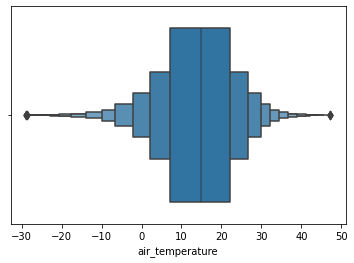

In [31]:
sn.boxenplot(weather['air_temperature'])

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='dew_temperature'>

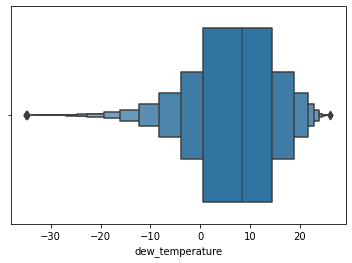

In [32]:
sn.boxenplot(weather['dew_temperature'])

In [33]:
weather['dew_temperature'].fillna(value=7.350158,inplace=True)
feature_changes['fill_null/weather/dew_temperature']=7.350158

In [34]:
#air temprature null values are less than 1% we can simply replace by mean because it doesn't change distribution
weather['air_temperature'].fillna(value=14.418106,inplace=True)

In [35]:
feature_changes['fill_null/weather/air_temperature']=14.418106

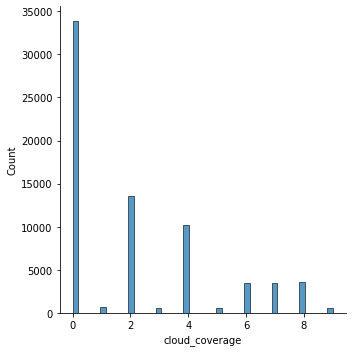

In [36]:
sn.displot(weather['cloud_coverage'])

In [37]:
weather.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [38]:
weather['timestamp']=pd.to_datetime(weather['timestamp'])

In [39]:
cloud_fill=weather.groupby('site_id')['cloud_coverage'].mean().to_dict()
precip_fill=weather.groupby('site_id')['precip_depth_1_hr'].mean().to_dict()

In [40]:
cloud_fill

{0: 3.0446104158255953,
 1: 0.08465608465608465,
 2: 1.9584694353709753,
 3: 3.8791358505254965,
 4: 1.867999121458379,
 5: 0.2906422018348624,
 6: 0.6476683937823834,
 7: nan,
 8: 3.0446104158255953,
 9: 0.6106726794438181,
 10: 0.37650031585596966,
 11: nan,
 12: 5.723091076356946,
 13: 2.873132664437012,
 14: 0.5622027076472741,
 15: 1.1099876695437731}

In [41]:
feature_changes['fill_null/weather/cloud_coverage']=cloud_fill
feature_changes['fill_null/weather/precip_depth_1_hr']=precip_fill
feature_changes['fill_null/weather/cloud_coverage_cloud_fill_nan']=weather['cloud_coverage'].mean()
feature_changes['fill_null/weather/precip_depth_1_hr_precip_fill_nan']=weather['precip_depth_1_hr'].mean()

In [42]:
def fill_cloud(site):
    if str(feature_changes['fill_null/weather/cloud_coverage'][site])=='nan':
        return feature_changes['fill_null/weather/cloud_coverage_cloud_fill_nan']
    else:
        return feature_changes['fill_null/weather/cloud_coverage'][site]
def fill_precip(site):
    if str(feature_changes['fill_null/weather/precip_depth_1_hr'][site])=='nan':
        return feature_changes['fill_null/weather/precip_depth_1_hr_precip_fill_nan']
    else:
        return feature_changes['fill_null/weather/precip_depth_1_hr'][site]

In [43]:
weather.loc[weather['cloud_coverage'].isnull()==True,'cloud_coverage']=weather.loc[weather['cloud_coverage'].isnull()==True,'site_id'].apply(fill_cloud)
weather.loc[weather['precip_depth_1_hr'].isnull()==True,'precip_depth_1_hr']=weather.loc[weather['precip_depth_1_hr'].isnull()==True,'site_id'].apply(fill_precip)

In [44]:
#replacing null values by least value beacuse its % is 7
weather['sea_level_pressure'].fillna(value=968.2,inplace=True)

In [45]:
feature_changes['fill_null/weather/sea_level_pressure']=968.2

In [46]:
#it may be degree wrt to north
weather['wind_direction'].unique()

array([  0.,  70., 250., 210., 290., 230., 200., 180., 220., 270., 300.,
       360.,  20.,  30.,  10., 350.,  60., 340., 330., 110., 320., 310.,
        50.,  40.,  nan,  80.,  90., 100., 120., 160., 130., 140., 190.,
       170., 240., 280., 150., 260., 174., 176.,  84., 198., 196., 202.])

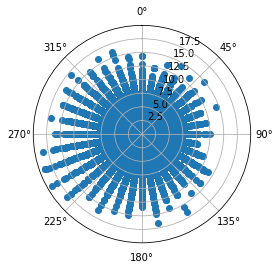

In [47]:
#https://stackoverflow.com/questions/32793953/seaborn-how-to-plot-wind-speed-v-direction-on-circular-plot
ax = plt.subplot(111, polar=True)
ax.scatter(x=[np.radians(x) for x in weather['wind_direction'].values], y=weather['wind_speed'].values)
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)

In [48]:
weather['wind_direction'].fillna(value=245,inplace=True)

In [49]:
feature_changes['fill_null/weather/wind_direction']=245

building anlysis

In [50]:
build.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


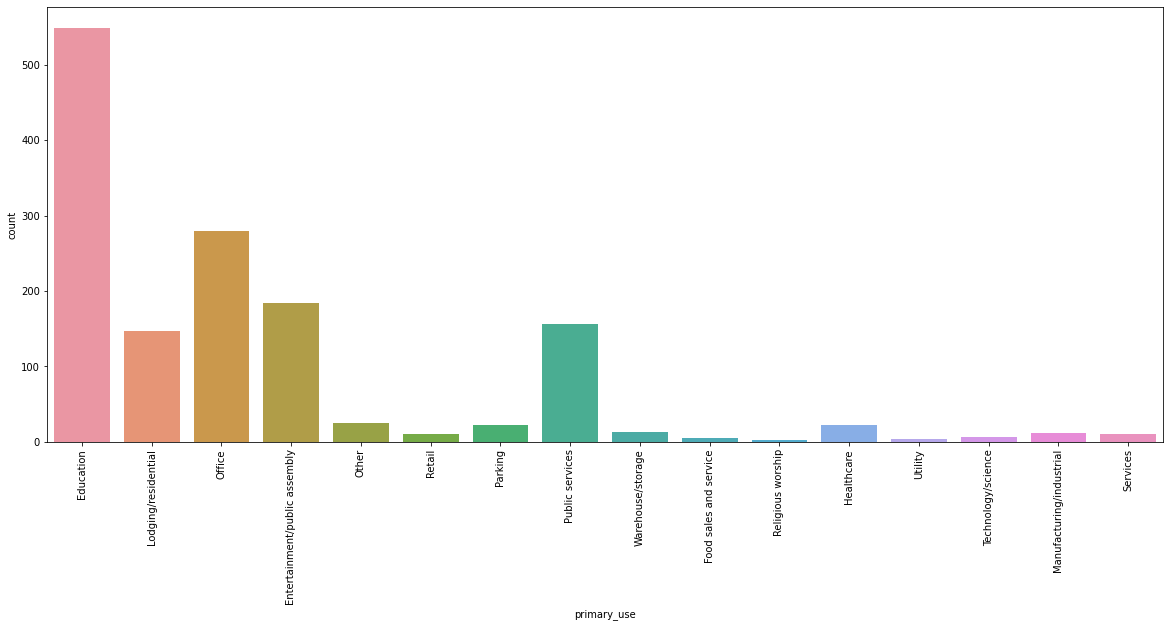

In [51]:
#let's see for what type of buildings the data is collected
plt.figure(figsize=(20,8))
sn.countplot(build['primary_use'])
plt.xticks(rotation=90)
plt.show()

<Figure size 1440x504 with 0 Axes>

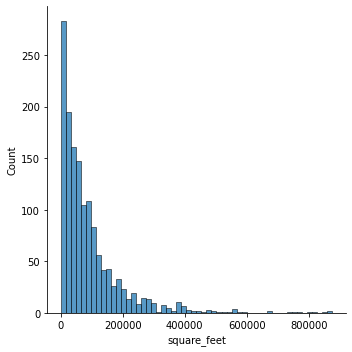

In [52]:
#distribution of size of area of the buildings covering
plt.figure(figsize=(20,7))
sn.displot(build['square_feet'])

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


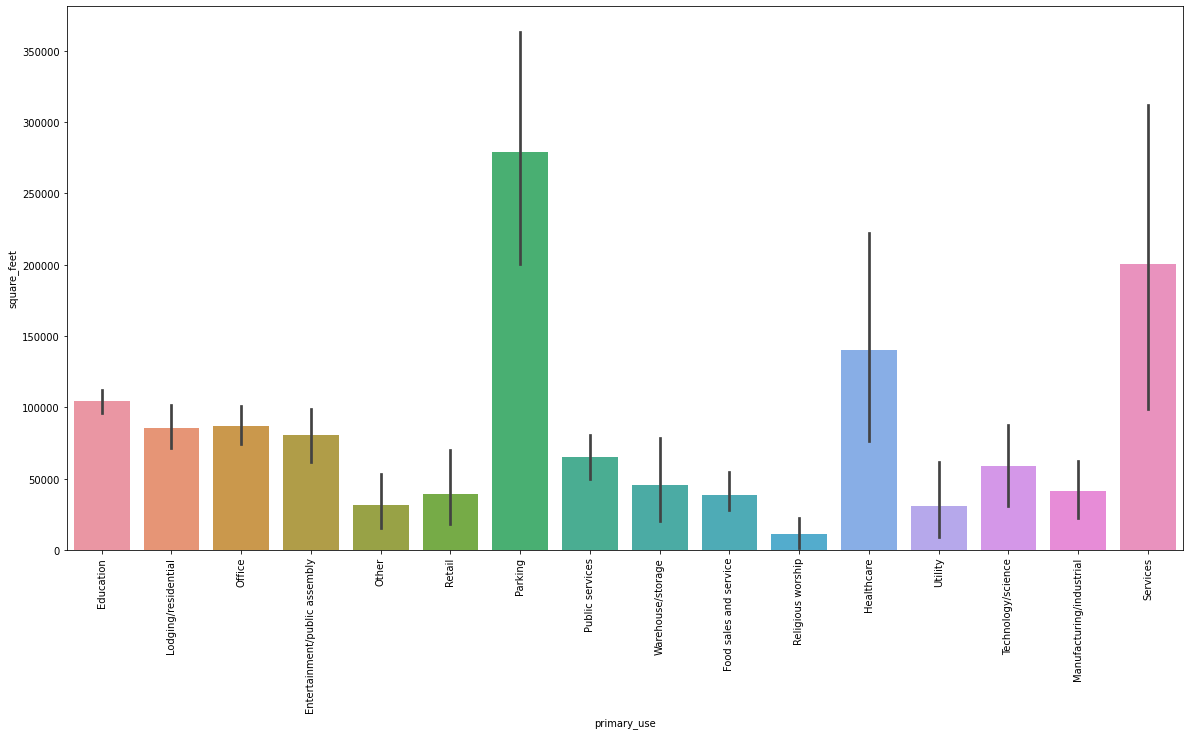

In [53]:
#just to check whether we are having what we expect to have
plt.figure(figsize=(20,10))
sn.barplot(build['primary_use'],build['square_feet'])
plt.xticks(rotation=90)
plt.show()

<AxesSubplot:xlabel='year_built', ylabel='Density'>

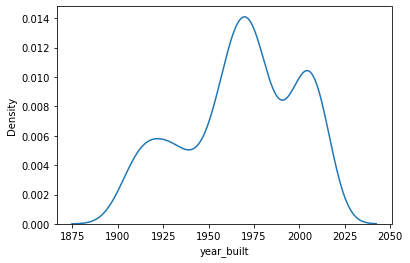

In [54]:
#how old are the buildings
sn.kdeplot(build['year_built'])

In [55]:
build.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [56]:
build['temp_floors']=build['floor_count']

In [57]:
build['temp_floors'].fillna(value=0,inplace=True)

In [58]:
d1=pd.DataFrame(build.groupby(by=['primary_use']).count()['temp_floors'])

In [59]:
d1

,temp_floors
primary_use,
Education,549
Entertainment/public assembly,184
Food sales and service,5
Healthcare,23
Lodging/residential,147
Manufacturing/industrial,12
Office,279
Other,25
Parking,22


In [60]:
d2=pd.DataFrame(build.groupby(by=['primary_use']).sum()['temp_floors'])

In [61]:
d2.rename(columns={'temp_floors':'summation'},inplace=True)

In [62]:
d3=d1.join(d2)

In [63]:
d3

,temp_floors,summation
primary_use,,
Education,549,814.0
Entertainment/public assembly,184,117.0
Food sales and service,5,0.0
Healthcare,23,1.0
Lodging/residential,147,114.0
Manufacturing/industrial,12,5.0
Office,279,149.0
Other,25,14.0
Parking,22,8.0


In [64]:
d3['avg_floors']=d3.apply(lambda x: np.ceil(x['summation']/x['temp_floors']),axis=1)

In [65]:
d3

,temp_floors,summation,avg_floors
primary_use,,,
Education,549,814.0,2.0
Entertainment/public assembly,184,117.0,1.0
Food sales and service,5,0.0,0.0
Healthcare,23,1.0,1.0
Lodging/residential,147,114.0,1.0
Manufacturing/industrial,12,5.0,1.0
Office,279,149.0,1.0
Other,25,14.0,1.0
Parking,22,8.0,1.0


In [66]:
floor_dict=d3.groupby(d3.index)['avg_floors'].sum().to_dict()

In [67]:
floor_dict

{'Education': 2.0,
 'Entertainment/public assembly': 1.0,
 'Food sales and service': 0.0,
 'Healthcare': 1.0,
 'Lodging/residential': 1.0,
 'Manufacturing/industrial': 1.0,
 'Office': 1.0,
 'Other': 1.0,
 'Parking': 1.0,
 'Public services': 1.0,
 'Religious worship': 0.0,
 'Retail': 1.0,
 'Services': 0.0,
 'Technology/science': 3.0,
 'Utility': 1.0,
 'Warehouse/storage': 1.0}

In [68]:
def get_floor(p):
    return floor_dict[p]

In [69]:
indexes=list(build[build['floor_count'].isnull()==True].index)

In [70]:
len(indexes)

1094

In [71]:
build.shape

(1449, 7)

In [72]:
for idx in indexes:
    build.loc[idx,'floor_count']=get_floor(str(build.loc[idx,'primary_use']))

In [73]:
feature_changes['fill_null/build/floor_count']=floor_dict

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='floor_count', ylabel='count'>

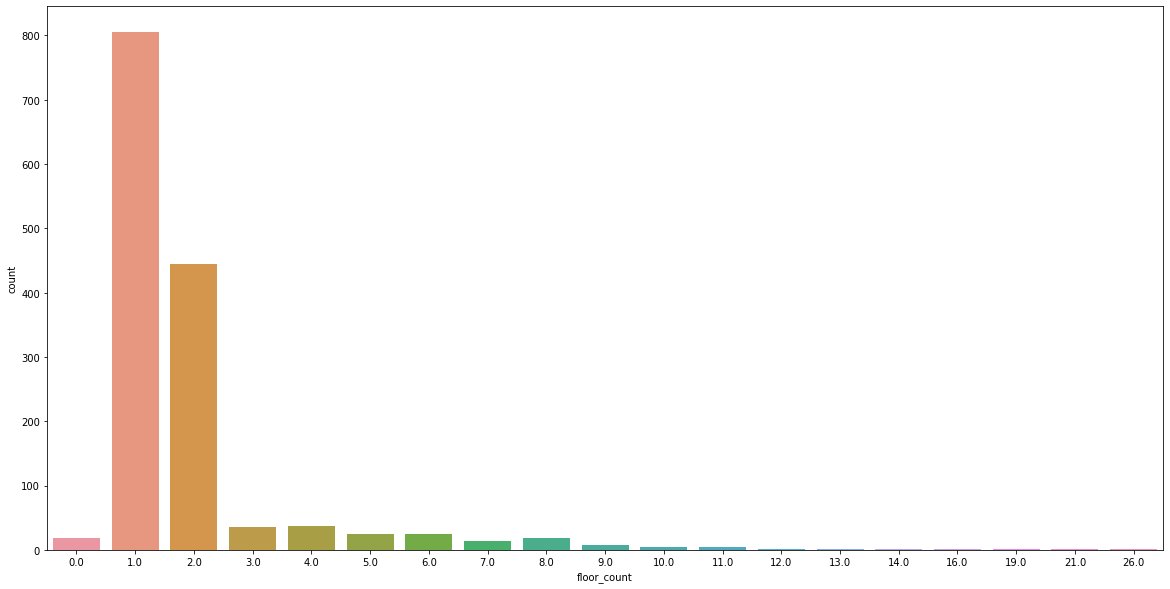

In [74]:
plt.figure(figsize=(20,10))
sn.countplot(build['floor_count'])

In [75]:
build.drop('temp_floors',axis=1,inplace=True)

In [76]:
build.groupby('site_id')['year_built'].max()

site_id
0     2016.0
1     2007.0
2     2014.0
3     2017.0
4     2016.0
5     2013.0
6        NaN
7     1995.0
8        NaN
9        NaN
10       NaN
11       NaN
12       NaN
13       NaN
14       NaN
15    2014.0
Name: year_built, dtype: float64

In [77]:
build.drop('year_built',axis=1,inplace=True)

In [78]:
weather.isna().sum()

site_id               0
timestamp             0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
dtype: int64

In [79]:
temp=pd.merge(left=df,
    right=build,
    left_on='building_id',
    right_on='building_id',how='left')

In [80]:
temp.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,floor_count
0,0,0,2016-01-01,0.0,0,Education,7432,2.0
1,1,0,2016-01-01,0.0,0,Education,2720,2.0
2,2,0,2016-01-01,0.0,0,Education,5376,2.0
3,3,0,2016-01-01,0.0,0,Education,23685,2.0
4,4,0,2016-01-01,0.0,0,Education,116607,2.0


In [81]:
from sklearn.preprocessing import LabelEncoder

In [82]:
primary_use_encoder=LabelEncoder()

In [83]:
build['primary_use']=primary_use_encoder.fit_transform(build['primary_use'])

In [84]:
primary_use_encoder.classes_

array(['Education', 'Entertainment/public assembly',
       'Food sales and service', 'Healthcare', 'Lodging/residential',
       'Manufacturing/industrial', 'Office', 'Other', 'Parking',
       'Public services', 'Religious worship', 'Retail', 'Services',
       'Technology/science', 'Utility', 'Warehouse/storage'], dtype=object)

In [85]:
encoders['primary_use']=primary_use_encoder

In [86]:
feature_changes['remove_cols/build']=['year_built']

In [87]:
feature_changes

{'fill_null/weather/wind_speed': 3.560527,
 'fill_null/weather/dew_temperature': 7.350158,
 'fill_null/weather/air_temperature': 14.418106,
 'fill_null/weather/cloud_coverage': {0: 3.0446104158255953,
  1: 0.08465608465608465,
  2: 1.9584694353709753,
  3: 3.8791358505254965,
  4: 1.867999121458379,
  5: 0.2906422018348624,
  6: 0.6476683937823834,
  7: nan,
  8: 3.0446104158255953,
  9: 0.6106726794438181,
  10: 0.37650031585596966,
  11: nan,
  12: 5.723091076356946,
  13: 2.873132664437012,
  14: 0.5622027076472741,
  15: 1.1099876695437731},
 'fill_null/weather/precip_depth_1_hr': {0: 1.3825572127974497,
  1: nan,
  2: 0.15773775381438568,
  3: 0.6918677799382363,
  4: 0.24859362443075275,
  5: nan,
  6: 0.797768162149852,
  7: 11.350205198358413,
  8: 1.3825572127974497,
  9: 0.7551578707397697,
  10: 0.45745288406624784,
  11: 11.350205198358413,
  12: nan,
  13: 0.8805153346254703,
  14: 0.7427395380745484,
  15: 3.4950088079859074},
 'fill_null/weather/cloud_coverage_cloud_fill

In [88]:
import pickle

In [89]:
with open('feature_changes','wb') as f:
    pickle.dump(feature_changes,f)

In [90]:
import pickle
with open('feature_changes','rb') as f:
    l=pickle.load(f)

In [91]:
l

{'fill_null/weather/wind_speed': 3.560527,
 'fill_null/weather/dew_temperature': 7.350158,
 'fill_null/weather/air_temperature': 14.418106,
 'fill_null/weather/cloud_coverage': {0: 3.0446104158255953,
  1: 0.08465608465608465,
  2: 1.9584694353709753,
  3: 3.8791358505254965,
  4: 1.867999121458379,
  5: 0.2906422018348624,
  6: 0.6476683937823834,
  7: nan,
  8: 3.0446104158255953,
  9: 0.6106726794438181,
  10: 0.37650031585596966,
  11: nan,
  12: 5.723091076356946,
  13: 2.873132664437012,
  14: 0.5622027076472741,
  15: 1.1099876695437731},
 'fill_null/weather/precip_depth_1_hr': {0: 1.3825572127974497,
  1: nan,
  2: 0.15773775381438568,
  3: 0.6918677799382363,
  4: 0.24859362443075275,
  5: nan,
  6: 0.797768162149852,
  7: 11.350205198358413,
  8: 1.3825572127974497,
  9: 0.7551578707397697,
  10: 0.45745288406624784,
  11: 11.350205198358413,
  12: nan,
  13: 0.8805153346254703,
  14: 0.7427395380745484,
  15: 3.4950088079859074},
 'fill_null/weather/cloud_coverage_cloud_fill

In [92]:
build.head()

,site_id,building_id,primary_use,square_feet,floor_count
0,0,0,0,7432,2.0
1,0,1,0,2720,2.0
2,0,2,0,5376,2.0
3,0,3,0,23685,2.0
4,0,4,0,116607,2.0


In [93]:
del temp
import gc
gc.collect()

10527

In [94]:
df.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


In [95]:
df=pd.merge(left=df,right=build,left_on='building_id',right_on='building_id',how='left')

In [96]:
#df['timestamp']=df['timestamp'].apply(lambda x: str(x))
#weather['timestamp']=weather['timestamp'].apply(lambda x: str(x))

there was a mistake in data given site 0 electric meter reading were not properly converted to units of kWh and are in kBTU. So converting it to KWh

In [97]:
df.loc[(df['site_id']==0)&(df['meter']==0),'meter_reading']=0.2931*df.loc[(df['site_id']==0)&(df['meter']==0),'meter_reading']

In [98]:
#df.to_csv('processed_df.csv',index=False)
#weather.to_csv('processed_weather.csv',index=False)

In [99]:
#with open('encoders.pkl','wb') as f:
#    pickle.dump(encoders,f)

In [100]:
#del l
#import gc
#gc.collect()

In [101]:
#del feature_changes,encoders
#gc.collect()

In [102]:
#del df
#gc.collect()

## next checkpoint

In [103]:
#import numpy as np
#import pandas as pd
#import matplotlib.pyplot as plt
#import seaborn as sn
#from tqdm import tqdm
#%matplotlib inline

In [104]:
#df=pd.read_csv('processed_df.csv')
#weather=pd.read_csv('processed_weather.csv')

In [105]:
df=pd.merge(left=df,right=weather,left_on=['site_id','timestamp'],right_on=['site_id','timestamp'],how='left')

In [106]:
del weather
import gc
gc.collect()

198

In [107]:
df.isna().sum()

building_id               0
meter                     0
timestamp                 0
meter_reading             0
site_id                   0
primary_use               0
square_feet               0
floor_count               0
air_temperature       90495
cloud_coverage        90495
dew_temperature       90495
precip_depth_1_hr     90495
sea_level_pressure    90495
wind_direction        90495
wind_speed            90495
dtype: int64

In [108]:
#df.drop(['month','day'],axis=1,inplace=True)

we got those because weather data is not given complete

In [109]:
#import pickle
#with open('feature_changes','rb') as f:
#    l=pickle.load(f)
#with open('encoders.pkl','rb') as f:
#    encoders=pickle.load(f)
    

In [110]:
df['air_temperature'].fillna(value=l['fill_null/weather/air_temperature'],inplace=True)
df['sea_level_pressure'].fillna(value=l['fill_null/weather/sea_level_pressure'],inplace=True)
df['wind_speed'].fillna(value=l['fill_null/weather/wind_speed'],inplace=True)
df['dew_temperature'].fillna(value=l['fill_null/weather/dew_temperature'],inplace=True)
df['wind_direction'].fillna(value=l['fill_null/weather/wind_direction'],inplace=True)

In [111]:
def fill_cloud(site):
    if str(feature_changes['fill_null/weather/cloud_coverage'][site])=='nan':
        return feature_changes['fill_null/weather/cloud_coverage_cloud_fill_nan']
    else:
        return feature_changes['fill_null/weather/cloud_coverage'][site]
def fill_precip(site):
    if str(feature_changes['fill_null/weather/precip_depth_1_hr'][site])=='nan':
        return feature_changes['fill_null/weather/precip_depth_1_hr_precip_fill_nan']
    else:
        return feature_changes['fill_null/weather/precip_depth_1_hr'][site]
    

In [112]:
#df['month']=df['timestamp'].dt.month
#df['day']=df['timestamp'].dt.day

In [113]:
df.isna().sum()

building_id               0
meter                     0
timestamp                 0
meter_reading             0
site_id                   0
primary_use               0
square_feet               0
floor_count               0
air_temperature           0
cloud_coverage        90495
dew_temperature           0
precip_depth_1_hr     90495
sea_level_pressure        0
wind_direction            0
wind_speed                0
dtype: int64

In [114]:
df.loc[df['cloud_coverage'].isnull()==True,'cloud_coverage']=df.loc[df['cloud_coverage'].isnull()==True,'site_id'].apply(fill_cloud)

In [115]:
df.loc[df['precip_depth_1_hr'].isnull()==True,'precip_depth_1_hr']=df.loc[df['precip_depth_1_hr'].isnull()==True,'site_id'].apply(fill_precip)

In [116]:
#df.drop('month',axis=1,inplace=True)
#df.drop('day',axis=1,inplace=True)

In [117]:
df.isna().sum()

building_id           0
meter                 0
timestamp             0
meter_reading         0
site_id               0
primary_use           0
square_feet           0
floor_count           0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
dtype: int64

In [118]:
df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0,0,7432,2.0,25.0,6.0,20.0,1.382557,1019.7,0.0,0.0
1,1,0,2016-01-01,0.0,0,0,2720,2.0,25.0,6.0,20.0,1.382557,1019.7,0.0,0.0
2,2,0,2016-01-01,0.0,0,0,5376,2.0,25.0,6.0,20.0,1.382557,1019.7,0.0,0.0
3,3,0,2016-01-01,0.0,0,0,23685,2.0,25.0,6.0,20.0,1.382557,1019.7,0.0,0.0
4,4,0,2016-01-01,0.0,0,0,116607,2.0,25.0,6.0,20.0,1.382557,1019.7,0.0,0.0


In [119]:
#df['month']=df['timestamp'].dt.month
#df['day']=df['timestamp'].dt.day

In [120]:
df['day_of_week']=df['timestamp'].dt.weekday
df['hour']=df['timestamp'].dt.hour
df['week_of_year']=df['timestamp'].dt.isocalendar().week
df['week_end']=np.where(df['timestamp'].dt.weekday<=4,0,1)
df.drop('timestamp',axis=1,inplace=True)

In [121]:
from sklearn.preprocessing import LabelEncoder

In [122]:
df.columns

Index(['building_id', 'meter', 'meter_reading', 'site_id', 'primary_use',
       'square_feet', 'floor_count', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed', 'day_of_week', 'hour', 'week_of_year',
       'week_end'],
      dtype='object')

In [123]:
categorical_columns=['building_id', 'meter', 'site_id', 'primary_use',
        'day_of_week','hour', 'week_of_year', 'week_end']

In [124]:
for col in ['building_id', 'meter', 'site_id','day_of_week','hour', 'week_of_year', 'week_end']:
    encoder=LabelEncoder()
    df[col]=encoder.fit_transform(df[col])
    encoders[col]=encoder

In [125]:
for col,encoder in encoders.items():
    print(f"for {col} we got {encoder.classes_}")

for primary_use we got ['Education' 'Entertainment/public assembly' 'Food sales and service'
 'Healthcare' 'Lodging/residential' 'Manufacturing/industrial' 'Office'
 'Other' 'Parking' 'Public services' 'Religious worship' 'Retail'
 'Services' 'Technology/science' 'Utility' 'Warehouse/storage']
for building_id we got [   0    1    2 ... 1446 1447 1448]
for meter we got [0 1 2 3]
for site_id we got [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
for day_of_week we got [0 1 2 3 4 5 6]
for hour we got [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
for week_of_year we got [1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51
 52 53]
for week_end we got [0 1]


In [126]:
df.columns

Index(['building_id', 'meter', 'meter_reading', 'site_id', 'primary_use',
       'square_feet', 'floor_count', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed', 'day_of_week', 'hour', 'week_of_year',
       'week_end'],
      dtype='object')

In [127]:
total_columns=['building_id', 'meter','site_id', 'primary_use',
       'square_feet', 'floor_count', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed', 'day_of_week', 'hour', 'week_of_year',
       'week_end']

In [128]:
with open("encoders.pkl",'wb') as f:
    pickle.dump(encoders,f)
with open("categorical_columns",'wb') as f:
    pickle.dump(categorical_columns,f)
with open("total_columns.pkl",'wb') as f:
    pickle.dump(total_columns,f)

In [129]:
#df.to_csv('data_final.csv',index=False)

In [130]:
#del total_columns,encoders,categorical_columns
#import gc
#gc.collect()

# Model building

In [131]:
#import numpy as np
#import pandas as pd
#import matplotlib.pyplot as plt
#import gc
#import seaborn as sn
#from tqdm import tqdm
#%matplotlib inline

In [132]:
#df=pd.read_csv("data_final.csv")

In [6]:
#https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


In [134]:
df=reduce_mem_usage(df,use_float16=True)

Memory usage of dataframe is 2930.50 MB
Memory usage after optimization is: 790.46 MB
Decreased by 73.0%


In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 18 columns):
 #   Column              Dtype  
---  ------              -----  
 0   building_id         int16  
 1   meter               int8   
 2   meter_reading       float32
 3   site_id             int8   
 4   primary_use         int8   
 5   square_feet         int32  
 6   floor_count         float16
 7   air_temperature     float16
 8   cloud_coverage      float16
 9   dew_temperature     float16
 10  precip_depth_1_hr   float16
 11  sea_level_pressure  float16
 12  wind_direction      float16
 13  wind_speed          float16
 14  day_of_week         int8   
 15  hour                int8   
 16  week_of_year        int8   
 17  week_end            int8   
dtypes: float16(8), float32(1), int16(1), int32(1), int8(7)
memory usage: 790.5 MB


In [136]:
df.head()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,day_of_week,hour,week_of_year,week_end
0,0,0,0.0,0,0,7432,2.0,25.0,6.0,20.0,1.382812,1019.5,0.0,0.0,4,0,52,0
1,1,0,0.0,0,0,2720,2.0,25.0,6.0,20.0,1.382812,1019.5,0.0,0.0,4,0,52,0
2,2,0,0.0,0,0,5376,2.0,25.0,6.0,20.0,1.382812,1019.5,0.0,0.0,4,0,52,0
3,3,0,0.0,0,0,23685,2.0,25.0,6.0,20.0,1.382812,1019.5,0.0,0.0,4,0,52,0
4,4,0,0.0,0,0,116607,2.0,25.0,6.0,20.0,1.382812,1019.5,0.0,0.0,4,0,52,0


In [137]:
df.isna().sum()

building_id           0
meter                 0
meter_reading         0
site_id               0
primary_use           0
square_feet           0
floor_count           0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
day_of_week           0
hour                  0
week_of_year          0
week_end              0
dtype: int64

how corelated are the features.

<AxesSubplot:>

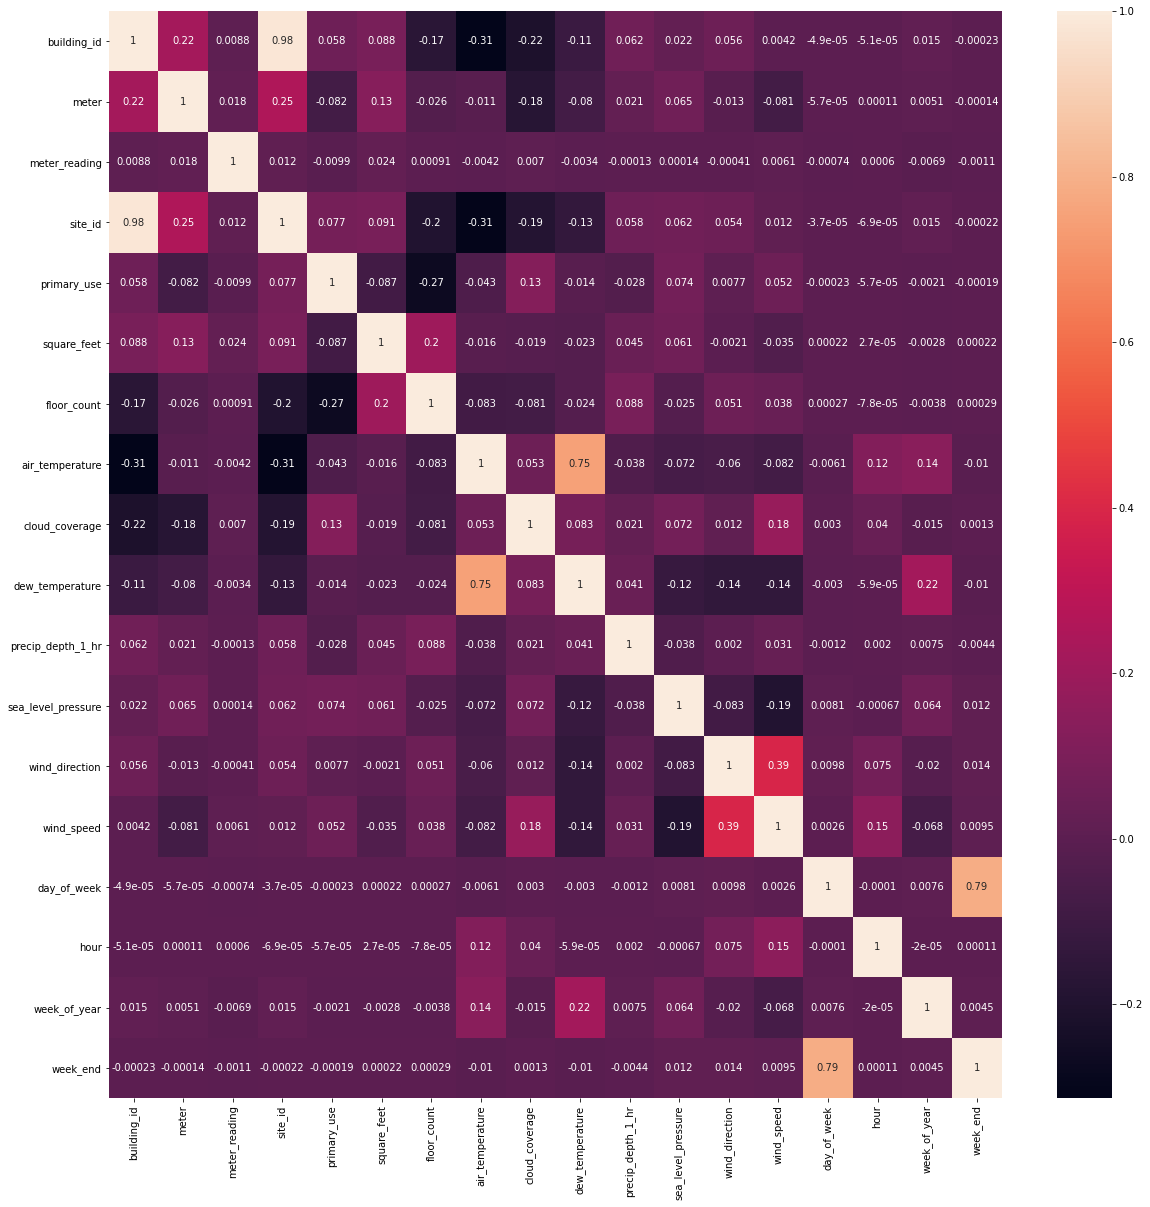

In [138]:
plt.figure(figsize=(20,20))
sn.heatmap(df.corr(),annot=True)

In [139]:
import optuna
import xgboost
from sklearn.metrics import mean_squared_error
import pickle

In [140]:
from sklearn.model_selection import KFold
kf=KFold(n_splits=5,shuffle=False)
df['kfold']=-1
x=df.drop('meter_reading',axis=1).values
y=df['meter_reading'].values
for i,(train,test) in enumerate(kf.split(x,y)):
    df.loc[test,'kfold']=i

In [141]:
del x,y
import gc
gc.collect()

37

In [142]:
df.columns

Index(['building_id', 'meter', 'meter_reading', 'site_id', 'primary_use',
       'square_feet', 'floor_count', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed', 'day_of_week', 'hour', 'week_of_year',
       'week_end', 'kfold'],
      dtype='object')

In [143]:
from xgboost import XGBRegressor

In [144]:
from tqdm import tqdm

In [145]:
#with open('total_columns.pkl','rb') as f:
#    total_columns=pickle.load(f)

# XGBOOST

In [146]:
df.head()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,day_of_week,hour,week_of_year,week_end,kfold
0,0,0,0.0,0,0,7432,2.0,25.0,6.0,20.0,1.382812,1019.5,0.0,0.0,4,0,52,0,0
1,1,0,0.0,0,0,2720,2.0,25.0,6.0,20.0,1.382812,1019.5,0.0,0.0,4,0,52,0,0
2,2,0,0.0,0,0,5376,2.0,25.0,6.0,20.0,1.382812,1019.5,0.0,0.0,4,0,52,0,0
3,3,0,0.0,0,0,23685,2.0,25.0,6.0,20.0,1.382812,1019.5,0.0,0.0,4,0,52,0,0
4,4,0,0.0,0,0,116607,2.0,25.0,6.0,20.0,1.382812,1019.5,0.0,0.0,4,0,52,0,0


In [146]:
total_columns

['building_id',
 'meter',
 'site_id',
 'primary_use',
 'square_feet',
 'floor_count',
 'air_temperature',
 'cloud_coverage',
 'dew_temperature',
 'precip_depth_1_hr',
 'sea_level_pressure',
 'wind_direction',
 'wind_speed',
 'day_of_week',
 'hour',
 'week_of_year',
 'week_end']

In [1]:
#def objective(trial):
#    max_depth=trial.suggest_int('max_depth',4,23)
#    subsample=trial.suggest_discrete_uniform('subsample',0.6,0.95,0.01)
#    colsample_bytree=trial.suggest_discrete_uniform('colsample_bytree',0.6,0.95,0.01)
#    reg_lambda=trial.suggest_loguniform("reg_lambda", 1e-3, 10)
#    min_child_weight=trial.suggest_int('min_child_weight',1,500,1)
#    gamma=trial.suggest_loguniform("gamma", 1e-3, 10)
#    lr=trial.suggest_uniform('learning_rate',0.01,0.3)
#    n_estimators=trial.suggest_int('n_estimators',100,2000,50)
#    scores=[]
#    for i in range(5):
#        train=df[df['kfold']!=i].drop('kfold',axis=1).reset_index(drop=True)
#        x_train=train.drop('meter_reading',axis=1)
#        x_train=x_train[total_columns].values
#        y_train=np.log1p(train['meter_reading'].values)
#        del train
#        gc.collect()
#        test=df[df['kfold']==i].drop('kfold',axis=1).reset_index(drop=True)
#        x_test=test.drop('meter_reading',axis=1)
#        x_test=x_test[total_columns].values
#        y_test=np.log1p(test['meter_reading'].values)
#        del test
#        gc.collect()
#        model=XGBRegressor(max_depth=max_depth,n_estimators=n_estimators,learning_rate=lr,
#               objective='reg:squarederror',min_child_weight=min_child_weight,
#               subsample=subsample,
#               colsample_bytree=colsample_bytree,gamma=gamma,
#               reg_lambda=reg_lambda,random_state=42,tree_method='gpu_hist')
#        model.fit(x_train, y_train,
#                 eval_set=[(x_test, y_test)],
#                 eval_metric='rmse',verbose=False)
#        del x_train,y_train,x_test,y_test
#        gc.collect()
#        score=model.evals_result()['validation_0']['rmse'][-1]
#        scores.append(score)
#    result=np.mean(scores)
#    return result
#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=150,show_progress_bar=True)

In [ ]:
study.best_params

In [ ]:
study.best_value

In [147]:
params={'max_depth': 6, 
         'subsample': 0.63,
         'colsample_bytree': 0.9299999999999999, 
         'reg_lambda': 0.04992100263298976, 
         'min_child_weight': 377, 
         'gamma': 6.921465266835858,
         'learning_rate': 0.041165557123617476,
         'n_estimators': 650,
         'objective':'reg:squarederror',
        'random_state':42,
        'tree_method':'gpu_hist'
       }


In [148]:
with open('model_params.json','wb') as f:
    pickle.dump(params,f)

In [149]:
scores=[]

In [151]:
for i in range(5):
    train=df[df['kfold']!=i].drop('kfold',axis=1).reset_index(drop=True)
    x_train=train.drop('meter_reading',axis=1)
    x_train=x_train[total_columns].values
    y_train=np.log1p(train['meter_reading'].values)
    del train
    gc.collect()
    test=df[df['kfold']==i].drop('kfold',axis=1).reset_index(drop=True)
    x_test=test.drop('meter_reading',axis=1)
    x_test=x_test[total_columns].values
    y_test=np.log1p(test['meter_reading'].values)
    del test
    gc.collect()
    model=XGBRegressor(**params)
    model.fit(x_train, y_train,
             eval_set=[(x_test, y_test)],
             eval_metric='rmse',verbose=False)
    del x_train,y_train,x_test,y_test
    gc.collect()
    score=model.evals_result()['validation_0']['rmse'][-1]
    scores.append(score)
    model.save_model(f'xgboost_{i}')
    del model
    gc.collect()

In [152]:
np.mean(scores)

1.2240435

In [153]:
del df,params,l,encoders,feature_changes
import gc
gc.collect()

44